#Urban Sound Classification with Transformer Models

This Colab notebook implements a Transformer-based deep learning model to classify short urban sound clips into 10 distinct categories using the UrbanSound8K dataset. The model is built with PyTorch and uses log-mel spectrograms as input features.

The notebook includes all major steps: audio preprocessing and augmentation, model architecture definition, training with cross-validation, performance evaluation using accuracy and F1-score, and inference on new audio samples.

#Imports/Unzip

In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import seaborn as sns
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report

In [ ]:
 #Unzip dataset
!wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
!tar -xzf urban8k.tgz
!rm urban8k.tgz

--2025-05-24 19:27:30--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.43.25, 188.185.45.92, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2025-05-24 19:27:30--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘urban8k.tgz’

urban8k.tgz         100%[===================>]   5.61G  21.2MB/s    in 4m 50s  

2025-05-24 19:32:21 (19.8 MB/s) - ‘urban8k.tgz’ saved [6023741708/6023741708]



In [ ]:
# Point to the dataset
metadata_path = "UrbanSound8K/metadata/UrbanSound8K.csv"
audio_path = "UrbanSound8K/audio/"

In [ ]:
# Load metadata
df = pd.read_csv(metadata_path)
df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


#Preprocessing Log-Mel

In [ ]:
# Preprocessing: Log-Mel Spectrogram parameters
SAMPLE_RATE = 22050
SOUND_DURATION = 2.95
HOP_LENGTH = 512
WINDOW_LENGTH = 512
N_MELS = 128

In [ ]:
# Feature extraction
def extract_features(df):
    X, y = [], []
    for i, row in tqdm(df.iterrows(), total=len(df)):
        file_path = os.path.join(audio_path, f"fold{row['fold']}", row["slice_file_name"])
        label = row["classID"]
        try:
            signal, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=SOUND_DURATION)
            mel_spec = librosa.feature.melspectrogram(
                y=signal, sr=sr,
                hop_length=HOP_LENGTH, win_length=WINDOW_LENGTH,
                n_mels=N_MELS
            )
            log_mel = librosa.power_to_db(mel_spec, ref=np.max)
            log_mel = librosa.util.fix_length(log_mel, size=128, axis=1)  # (n_mels, time)
            X.append(log_mel.T)
            y.append(label)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    return np.array(X), np.array(y)

#Data Augmentation

In [ ]:
# Augmentation: Add Gaussian Noise
def add_noise(mel, noise_level=0.005):
    noise = np.random.randn(*mel.shape) * noise_level
    return mel + noise

In [ ]:
# Augmentation: Time Shifting
def time_shift(mel, shift_max=5):
    shift = np.random.randint(-shift_max, shift_max)
    return np.roll(mel, shift, axis=0)

In [ ]:
# Augmentation: Time Masking
def time_mask(mel, mask_param=10):
    mel = mel.copy()
    t = mel.shape[0]
    t0 = random.randint(0, t - 1)
    t_mask = random.randint(1, mask_param)
    mel[t0:t0 + t_mask] = 0
    return mel

In [ ]:
def freq_mask(mel, mask_param=15):
    mel = mel.copy()
    num_mels = mel.shape[1]
    f0 = random.randint(0, num_mels - mask_param)
    mel[:, f0:f0 + mask_param] = 0
    return mel

In [ ]:
# Augmentation wrapper
def apply_augmentations(mel):
    if random.random() < 0.5: mel = add_noise(mel)
    if random.random() < 0.5: mel = time_shift(mel)
    if random.random() < 0.5: mel = time_mask(mel)
    if random.random() < 0.5: mel = freq_mask(mel)
    return mel

#Transformer Model

In [ ]:
# Dataset & Model definitions
class SoundDataset(Dataset):
    def __init__(self, X, y, augment=False):
        self.X = X
        self.y = y
        self.augment = augment
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        if self.augment:
            x = apply_augmentations(x)
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :].to(x.device)

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, num_classes):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dropout=0.2,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(model_dim, num_classes)
    def forward(self, x):
        x = self.input_fc(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.classifier(x)

#10-Fold Cross Validation with OneCycleLR Scheduler

In [ ]:
# Load or extract features
X, y = extract_features(df)
np.save("X1.npy", X)
np.save("y1.npy", y)

 41%|████      | 3555/8732 [01:07<01:30, 57.07it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1323
  warnings.warn(
 95%|█████████▌| 8323/8732 [02:35<00:04, 83.21it/s]/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
100%|██████████| 8732/8732 [02:43<00:00, 53.40it/s]


In [ ]:
X = np.load("X1.npy")
y = np.load("y1.npy")

In [ ]:
NUM_CLASSES = len(np.unique(y))
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
all_fold_histories = []
final_preds, final_labels = [], []

for fold in range(1, 11):
    print(f"\n Fold {fold}/10")
    train_idx = df[df['fold'] != fold].index
    test_idx  = df[df['fold'] == fold].index
    X_train, y_train = X[train_idx], y[train_idx]
    X_test,  y_test  = X[test_idx],  y[test_idx]

    # Normalize
    mean, std = X_train.mean(), X_train.std()
    X_train = (X_train - mean) / std
    X_test  = (X_test  - mean) / std

    train_ds = SoundDataset(X_train, y_train, augment=True)
    test_ds  = SoundDataset(X_test, y_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

    model = TransformerClassifier(
        input_dim=X.shape[2], model_dim=128,
        num_heads=4, num_layers=2,
        num_classes=NUM_CLASSES
    ).to(DEVICE)

    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS
    )
    criterion = nn.CrossEntropyLoss()

    def compute_accuracy(loader):
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                preds = model(xb).argmax(dim=1)
                correct += (preds == yb).sum().item()
                total   += yb.size(0)
        return correct / total

    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_acc = compute_accuracy(train_loader)
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                loss = criterion(model(xb), yb)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(test_loader)
        val_acc = compute_accuracy(test_loader)

        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}: Train loss {avg_train_loss:.4f}, Train acc {train_acc:.4f}, Val loss {avg_val_loss:.4f}, Val acc {val_acc:.4f}")

    all_fold_histories.append(history)

    # Collect preds for confusion matrix
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(DEVICE)
            preds = model(xb).argmax(dim=1).cpu()
            final_preds.extend(preds)
            final_labels.extend(yb)

    print(classification_report(final_labels[-len(test_ds):], final_preds[-len(test_ds):]))


 Fold 1/10
Epoch 1: Train loss 1.7701, Train acc 0.4410, Val loss 1.5585, Val acc 0.4433
Epoch 2: Train loss 1.4358, Train acc 0.5231, Val loss 1.4925, Val acc 0.4903
Epoch 3: Train loss 1.3072, Train acc 0.6086, Val loss 1.4765, Val acc 0.5292
Epoch 4: Train loss 1.1486, Train acc 0.6438, Val loss 1.4755, Val acc 0.5556
Epoch 5: Train loss 1.0595, Train acc 0.6654, Val loss 1.2509, Val acc 0.6254
Epoch 6: Train loss 0.9820, Train acc 0.7066, Val loss 1.0887, Val acc 0.6541
Epoch 7: Train loss 0.8790, Train acc 0.7316, Val loss 1.3966, Val acc 0.5819
Epoch 8: Train loss 0.8182, Train acc 0.7642, Val loss 1.3737, Val acc 0.6208
Epoch 9: Train loss 0.7223, Train acc 0.7432, Val loss 1.3487, Val acc 0.6300
Epoch 10: Train loss 0.6305, Train acc 0.7992, Val loss 1.5134, Val acc 0.6254
Epoch 11: Train loss 0.5746, Train acc 0.8365, Val loss 1.4397, Val acc 0.6151
Epoch 12: Train loss 0.4884, Train acc 0.8603, Val loss 1.5588, Val acc 0.6151
Epoch 13: Train loss 0.4306, Train acc 0.8927, Va

#Visualizations

In [ ]:
bar_width = 0.35
folds = np.arange(1, 11)

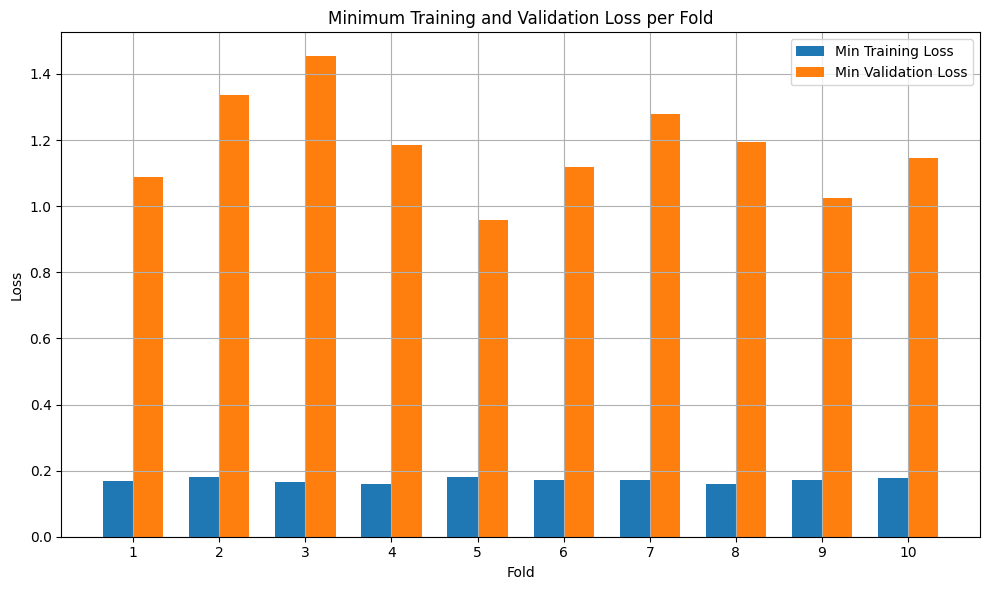

In [ ]:
# Visualize minimum loss for training and validation across folds
min_train_losses = [min(h['train_loss']) for h in all_fold_histories]
min_val_losses = [min(h['val_loss']) for h in all_fold_histories]

plt.figure(figsize=(10, 6))
plt.bar(folds - bar_width/2, min_train_losses, width=bar_width, label='Min Training Loss')
plt.bar(folds + bar_width/2, min_val_losses, width=bar_width, label='Min Validation Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.title('Minimum Training and Validation Loss per Fold')
plt.xticks(folds)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

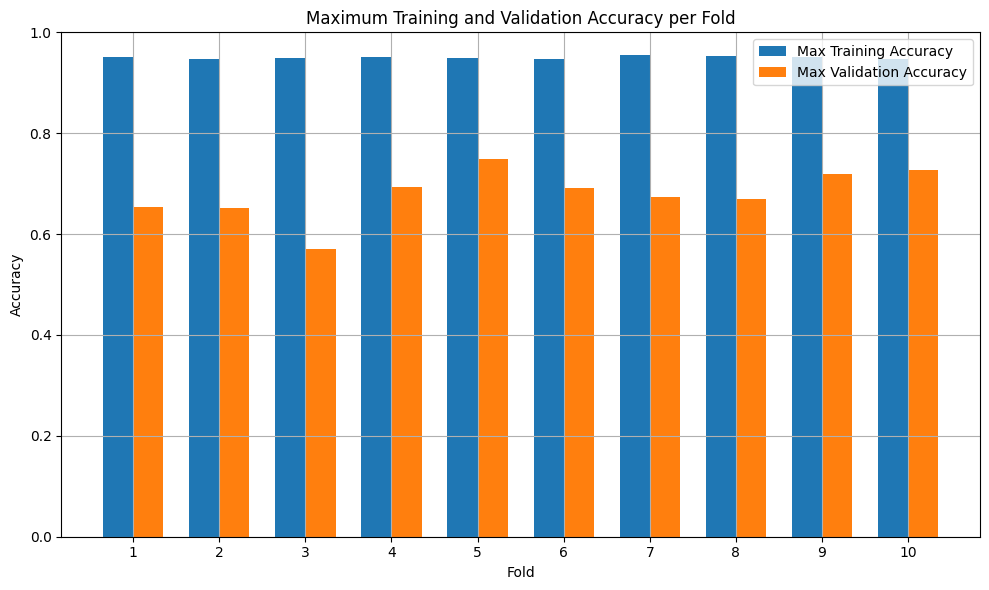

In [ ]:
# Visualize maximum accuracy for training and validation across folds
max_train_accs = [max(h['train_acc']) for h in all_fold_histories]
max_val_accs = [max(h['val_acc']) for h in all_fold_histories]

plt.figure(figsize=(10, 6))
plt.bar(folds - bar_width/2, max_train_accs, width=bar_width, label='Max Training Accuracy')
plt.bar(folds + bar_width/2, max_val_accs, width=bar_width, label='Max Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Maximum Training and Validation Accuracy per Fold')
plt.xticks(folds)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate standard deviation per fold
train_loss_std = [np.std(h['train_loss']) for h in all_fold_histories]
val_loss_std = [np.std(h['val_loss']) for h in all_fold_histories]
train_acc_std = [np.std(h['train_acc']) for h in all_fold_histories]
val_acc_std = [np.std(h['val_acc']) for h in all_fold_histories]

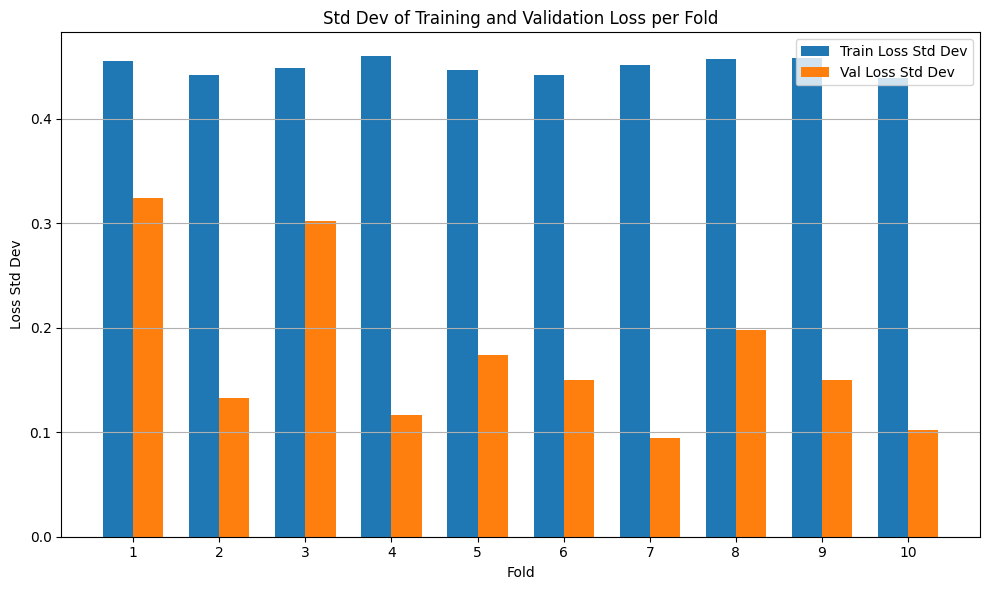

In [ ]:
# Loss Std Dev Plot
plt.figure(figsize=(10, 6))
plt.bar(folds - bar_width/2, train_loss_std, width=bar_width, label='Train Loss Std Dev')
plt.bar(folds + bar_width/2, val_loss_std, width=bar_width, label='Val Loss Std Dev')
plt.xlabel('Fold')
plt.ylabel('Loss Std Dev')
plt.title('Std Dev of Training and Validation Loss per Fold')
plt.xticks(folds)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

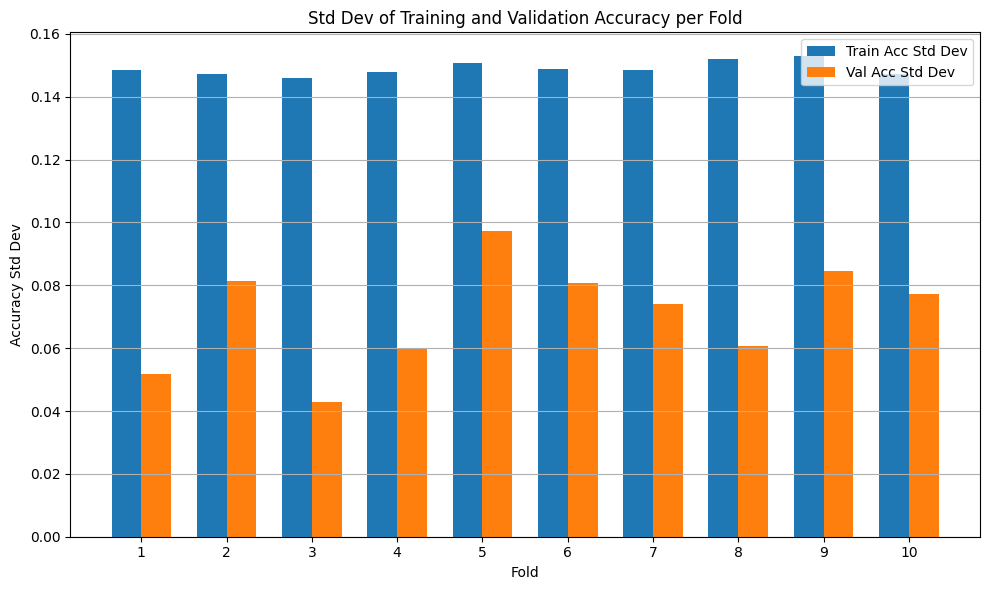

In [ ]:
# Accuracy Std Dev Plot
plt.figure(figsize=(10, 6))
plt.bar(folds - bar_width/2, train_acc_std, width=bar_width, label='Train Acc Std Dev')
plt.bar(folds + bar_width/2, val_acc_std, width=bar_width, label='Val Acc Std Dev')
plt.xlabel('Fold')
plt.ylabel('Accuracy Std Dev')
plt.title('Std Dev of Training and Validation Accuracy per Fold')
plt.xticks(folds)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

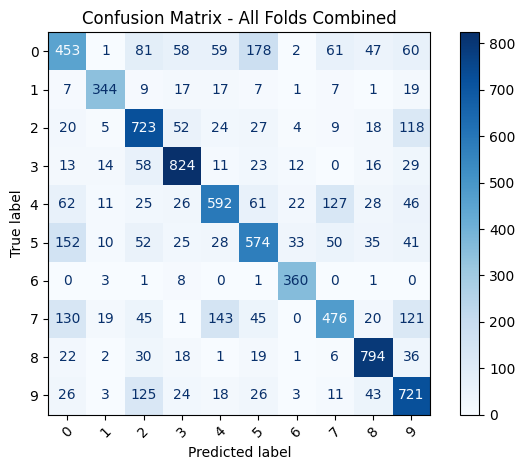

In [ ]:
# Confusion matrix after all folds
cm = confusion_matrix(final_labels, final_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - All Folds Combined')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


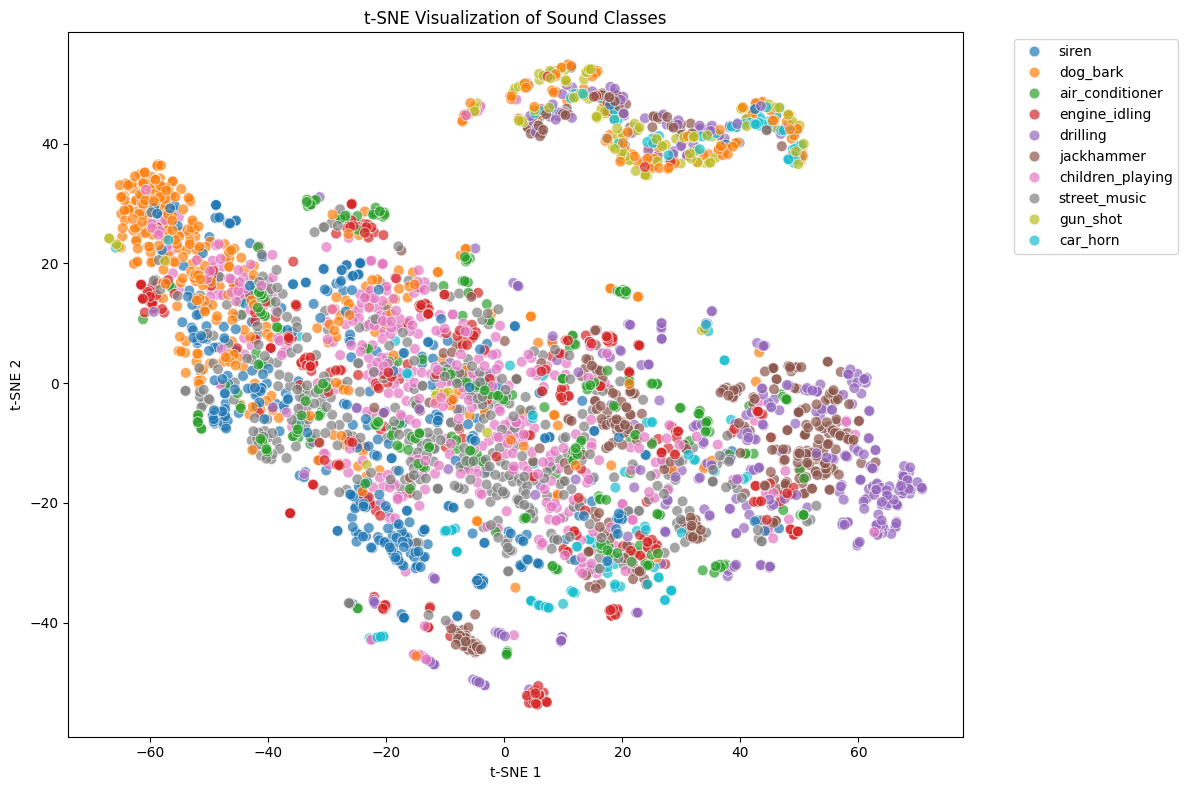

In [ ]:
# t-SNE Visualization of Sound Classes
sample_size = 3500
indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X[indices]
y_sample = y[indices]

# Flatten each (128, 128) mel-spectrogram into a vector
X_flat = X_sample.reshape(sample_size, -1)

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_embedded = tsne.fit_transform(X_flat)

# Extract class names
class_names = df[['classID', 'class']].drop_duplicates().sort_values('classID')['class'].tolist()
label_names = [class_names[label] for label in y_sample]

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=label_names, palette='tab10', s=60, alpha=0.7)
plt.title('t-SNE Visualization of Sound Classes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()

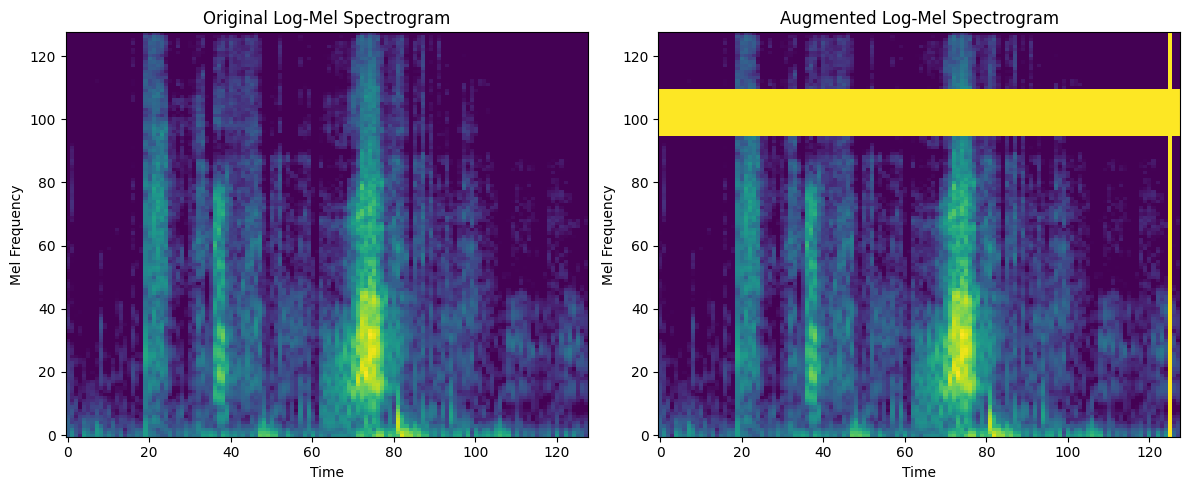

In [ ]:
# Original vs Augmented Log-Mel Spectogram
sample_idx = np.random.randint(len(X))
original_mel = X[sample_idx]
augmented_mel = apply_augmentations(original_mel)

# Plot side-by-side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Original
axs[0].imshow(original_mel.T, aspect='auto', origin='lower')
axs[0].set_title("Original Log-Mel Spectrogram")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Mel Frequency")

# Augmented
axs[1].imshow(augmented_mel.T, aspect='auto', origin='lower')
axs[1].set_title("Augmented Log-Mel Spectrogram")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Mel Frequency")

plt.tight_layout()
plt.show()